In [1]:
import os
import gc
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:3


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])

In [6]:
# 5.250.000, 10.080.000
len(raw_train)

5250000

> ### Train-test-split

In [7]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [8]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1

In [9]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

In [10]:
X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [11]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)

> ### Scaling

In [12]:
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

> ### Dataset and dataloader

In [13]:
def correct(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

In [14]:
class DataTEP(Dataset):

    def __init__(self, X, kind):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')
        
        self.max_length = self.X['sample'].max()

        if kind == 'train_val':
            self.s_list = [100]
            self.l_list = [100] # !!!!!
        else:
            self.s_list = [0]
            self.l_list = list(range(160, self.max_length + 1))
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique() * len(self.s_list) * len(self.l_list)
    
    def __getitem__(self, idx):
        
        fault_sim_idx = idx // (len(self.s_list) * len(self.l_list))
    
        start_length_idxs = idx % (len(self.s_list) * len(self.l_list))
        
        start_idx = self.s_list[start_length_idxs // len(self.l_list)]
        seq_length = self.l_list[start_length_idxs % len(self.l_list)]

        features = self.X.loc[fault_sim_idx][self.features].values[start_idx : (start_idx+seq_length), :]
        target = self.X.loc[fault_sim_idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [15]:
BATCH_SIZE = 64
NUM_CLASSES = 21

In [16]:
def collate_fn(batch):

    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
        
    lengths = torch.LongTensor([len(x) for x in sequences])
    lengths, idx = lengths.sort(0, descending=True)
    
    sequences = [sequences[i] for i in idx]
    
    labels = torch.tensor(labels, dtype=torch.long)[idx]
    
    sequences_padded = pad_sequence(sequences, batch_first=True)

    return sequences_padded, lengths, labels

In [17]:
train_ds = DataTEP(X_train, kind='train_val')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

val_ds = DataTEP(X_val, kind='train_val')
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

# test_ds = DataTEP(X_test, kind='test')
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

In [18]:
len(train_ds), len(val_ds)
# len(test_ds)

(8400, 2100)

In [19]:
gc.collect()

0

> ### Models

In [20]:
class UniRNN(torch.nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
            
    def forward(self, x, x_length):
        
        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_rnn_out, _ = self.rnn(x_packed)
        
        x_unpacked, __ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        x = self.head(x_unpacked[:, -1])
        
        return x

In [21]:
class AttentionModel(torch.nn.Module):
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        rnn_cell = getattr(nn, RNN_TYPE)

        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size, 
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        dropout=0.4,
                        batch_first=True
                )
        
        self.head = nn.Sequential(
#                         nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.output_size),
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )

    def attention(self, lstm_output):
        
        last_hidden = lstm_output[:, -1, :]
        attn_weights = torch.bmm(lstm_output, last_hidden.unsqueeze(2)).squeeze(2)
        
        soft_attn_weights = F.softmax(attn_weights, dim=1)
    
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state
    
    def forward(self, x, x_length):

        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_rnn_out, _ = self.rnn(x_packed)
        
        x_unpacked, __ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        attention_out = self.attention(x_unpacked)
        x = self.head(attention_out)

        return x

In [22]:
class TransformerModel(torch.nn.Module):
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DROPOUT):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.dropout = DROPOUT

        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
                        d_model=self.input_size, 
                        nhead=4, 
                        dim_feedforward=self.hidden_size, 
                        dropout=self.dropout, 
                        activation='relu'
                )
        
        
        self.transformer_encoder = nn.TransformerEncoder(
                        encoder_layer=transformer_encoder_layer, 
                        num_layers=self.num_layers, 
                        norm=None
                )
        
        self.weighted_mean = nn.Conv1d(
                        in_channels=self.input_size, 
                        out_channels=self.input_size, 
                        kernel_size=100, 
                        groups=self.input_size)
    
        self.head = nn.Sequential(
                        nn.Dropout(p=0.2),
                        nn.Linear(in_features=52, out_features=self.output_size),
#                         nn.Linear(in_features=52, out_features=self.linear_size),
#                         nn.ReLU(),
#                         nn.Dropout(p=0.4),
#                         nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def forward(self, x, x_length=None):
        """
        src: (S, N, E) = (sequence_length, batch_size, n_features)
        src_key_padding_mask: (N, S) = (batch_size, sequence_length)
        """
    
        x_mask = torch.zeros(x.size(0), x.size(1), dtype=bool, device=x.device)
        
        for i in range(len(x)):
            x_mask[i, x_length[i]:] = True

        x = self.transformer_encoder(src=x.transpose(0, 1), src_key_padding_mask=x_mask)
        x = x.permute(1, 2, 0)
        x = self.weighted_mean(x)
        x = x.squeeze(-1)
        x = self.head(x)

        return x

In [31]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

NUM_LAYERS = 2
HIDDEN_SIZE = 256
LINEAR_SIZE = 128
BIDIRECTIONAL = True

RNN_TYPE = "GRU"

> ### Model initialization

In [32]:
model = UniRNN(
            RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
            LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, 
            DESCRIPTION='simple_model_for_metrics'
        )

# model = AttentionModel(
#             RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
#             LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL
#         )

# model = TransformerModel(NUM_LAYERS=6, INPUT_SIZE=52, HIDDEN_SIZE=128, LINEAR_SIZE=52, OUTPUT_SIZE=21, DROPOUT=0.4)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

torch.manual_seed(42)
np.random.seed(42)

In [33]:
for i, (X_batch, X_lengths, y_batch) in enumerate(train_dl):
    if i < 1:
        print(type(X_batch), type(X_lengths), type(y_batch))
        print(len(X_batch), len(X_lengths), len(y_batch))
        print(X_lengths)
        X_batch, y_batch_train = X_batch.to(device), y_batch.to(device)
        y_pred_train = model(X_batch, X_lengths)
        print("y_batch_train.size()", y_batch.size())
        print("y_pred_train.size()", y_pred_train.size(), '\n')
    else:
        break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
64 64 64
tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100])
y_batch_train.size() torch.Size([64])
y_pred_train.size() torch.Size([64, 21]) 



In [34]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"model total parameters: {n_params}")
print(n_params / 1727253)

model total parameters: 1727253
1.0


In [35]:
# writer = SummaryWriter(comment=f'NL{NUM_LAYERS}_H{HIDDEN_SIZE}_L{LINEAR_SIZE}_B{BIDIRECTIONAL}_S{-100}')
writer = SummaryWriter(
    log_dir=f"metrics/{datetime.today().strftime('%d%b-%H-%M')}"
    )

In [36]:
ls metrics/

20May-10-35/  20May-10-59/  20May-17-03/  20May-19-30/
20May-10-39/  20May-15-59/  20May-17-54/  20May-20-03/


> ### Training

In [37]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

best_model_acc = 0
best_model_epoch = 0

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f'Epoch: {epoch}, Learning Rate: {scheduler.get_last_lr()[0]}\n')

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, X_batch_lengths_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, X_batch_lengths_train, y_batch_train =\
                    X_batch_train.to(device), X_batch_lengths_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train, X_batch_lengths_train)
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size()[0]
        correct_train_epoch += correct(y_pred_train, y_batch_train)
        n_train += y_batch_train.size()[0]

    scheduler.step()
    model.eval()

    with torch.no_grad():
        
#         for item in model.parameters():
#             print(item.grad.mean())
        
        for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val, X_batch_lengths_val)
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size()[0]
            correct_val_epoch += correct(y_pred_val, y_batch_val)
            n_val += y_batch_val.size()[0]
            
    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
    if accuracy_val_epoch > best_model_acc:
        
        best_model_state_dict = model.state_dict()
        best_model_acc = accuracy_val_epoch
        best_model_epoch = epoch
        
#     scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch}, mean loss val: {loss_mean_val_epoch}")
    print(f"accuracy train: {accuracy_train_epoch}, accuracy val: {accuracy_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




epoch time: 25.825894117355347
mean loss train: 1.6618341747919718, mean loss val: 0.9971007767106805
accuracy train: 0.4527380952380952, accuracy val: 0.6190476190476191
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




epoch time: 25.126811027526855
mean loss train: 0.855368264062064, mean loss val: 0.6381470714509487
accuracy train: 0.6722619047619047, accuracy val: 0.7238095238095238
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




epoch time: 25.12648582458496
mean loss train: 0.4684672566822597, mean loss val: 0.35909858829563573
accuracy train: 0.7917857142857143, accuracy val: 0.8085714285714286
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




epoch time: 25.08394479751587
mean loss train: 0.42632303953170775, mean loss val: 0.33798274289949665
accuracy train: 0.8007142857142857, accuracy val: 0.8223809523809524
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




epoch time: 25.430212259292603
mean loss train: 0.33877686001005625, mean loss val: 0.31820082005997563
accuracy train: 0.8297619047619048, accuracy val: 0.8366666666666667
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




epoch time: 26.86836051940918
mean loss train: 0.32653997932161605, mean loss val: 0.3395370315361236
accuracy train: 0.8320238095238095, accuracy val: 0.8357142857142857
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




epoch time: 25.975271701812744
mean loss train: 0.30881312801724387, mean loss val: 0.280221769696218
accuracy train: 0.8410714285714286, accuracy val: 0.8519047619047619
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




epoch time: 26.96814799308777
mean loss train: 0.2979164470945086, mean loss val: 0.2776612903958206
accuracy train: 0.8472619047619048, accuracy val: 0.8542857142857143
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




epoch time: 24.522852659225464
mean loss train: 0.27609432941391354, mean loss val: 0.26931017716733985
accuracy train: 0.8547619047619047, accuracy val: 0.8552380952380952
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




epoch time: 28.73374605178833
mean loss train: 0.27101724800609406, mean loss val: 0.26957282702129476
accuracy train: 0.8528571428571429, accuracy val: 0.8528571428571429
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001




epoch time: 24.934152841567993
mean loss train: 0.26775180266017007, mean loss val: 0.27328526201702646
accuracy train: 0.8560714285714286, accuracy val: 0.8561904761904762
---------------------------------------------------------------------------------------------------
Epoch: 11, Learning Rate: 0.001




epoch time: 25.46327495574951
mean loss train: 0.2679222211383638, mean loss val: 0.2699541879835721
accuracy train: 0.8557142857142858, accuracy val: 0.8523809523809524
---------------------------------------------------------------------------------------------------
Epoch: 12, Learning Rate: 0.001




epoch time: 24.41690945625305
mean loss train: 0.27113629636310393, mean loss val: 0.27520218485875897
accuracy train: 0.8566666666666667, accuracy val: 0.8547619047619047
---------------------------------------------------------------------------------------------------
Epoch: 13, Learning Rate: 0.001




epoch time: 26.13440752029419
mean loss train: 0.26829726122674485, mean loss val: 0.26908865792411407
accuracy train: 0.8585714285714285, accuracy val: 0.8566666666666667
---------------------------------------------------------------------------------------------------
Epoch: 14, Learning Rate: 0.001




epoch time: 25.021674633026123
mean loss train: 0.267459781283424, mean loss val: 0.2681250681196027
accuracy train: 0.8590476190476191, accuracy val: 0.8566666666666667
---------------------------------------------------------------------------------------------------
Epoch: 15, Learning Rate: 0.001




epoch time: 25.510692358016968
mean loss train: 0.26744628730274383, mean loss val: 0.2707379654475586
accuracy train: 0.8582142857142857, accuracy val: 0.8561904761904762
---------------------------------------------------------------------------------------------------
Epoch: 16, Learning Rate: 0.001




epoch time: 26.35884380340576
mean loss train: 0.26807094108490714, mean loss val: 0.268017228898541
accuracy train: 0.8555952380952381, accuracy val: 0.8566666666666667
---------------------------------------------------------------------------------------------------
Epoch: 17, Learning Rate: 0.001




epoch time: 25.814900159835815
mean loss train: 0.26650449082964944, mean loss val: 0.26839281354632044
accuracy train: 0.8546428571428571, accuracy val: 0.8590476190476191
---------------------------------------------------------------------------------------------------
Epoch: 18, Learning Rate: 0.001




epoch time: 24.813353061676025
mean loss train: 0.2665965110915048, mean loss val: 0.2743454787844565
accuracy train: 0.8583333333333333, accuracy val: 0.8547619047619047
---------------------------------------------------------------------------------------------------
Epoch: 19, Learning Rate: 0.001




epoch time: 25.878329515457153
mean loss train: 0.331034761213121, mean loss val: 0.273065731184837
accuracy train: 0.8432142857142857, accuracy val: 0.8509523809523809
---------------------------------------------------------------------------------------------------
Epoch: 20, Learning Rate: 0.001




epoch time: 25.773908138275146
mean loss train: 0.2708225076539176, mean loss val: 0.2683575610887385
accuracy train: 0.8589285714285714, accuracy val: 0.8604761904761905
---------------------------------------------------------------------------------------------------
Epoch: 21, Learning Rate: 0.001




epoch time: 25.424837112426758
mean loss train: 0.26799465451921733, mean loss val: 0.2662748101779393
accuracy train: 0.8595238095238096, accuracy val: 0.8585714285714285
---------------------------------------------------------------------------------------------------
Epoch: 22, Learning Rate: 0.001




epoch time: 25.61487364768982
mean loss train: 0.2668502100876399, mean loss val: 0.27193304334365254
accuracy train: 0.8601190476190477, accuracy val: 0.8466666666666667
---------------------------------------------------------------------------------------------------
Epoch: 23, Learning Rate: 0.001




epoch time: 25.559358835220337
mean loss train: 0.2684365623337882, mean loss val: 0.2710710859298498
accuracy train: 0.8585714285714285, accuracy val: 0.8533333333333334
---------------------------------------------------------------------------------------------------
Epoch: 24, Learning Rate: 0.001




epoch time: 25.43053150177002
mean loss train: 0.26805985882168726, mean loss val: 0.2688122109004533
accuracy train: 0.8539285714285715, accuracy val: 0.8566666666666667
---------------------------------------------------------------------------------------------------
Epoch: 25, Learning Rate: 0.0005




epoch time: 25.213754892349243
mean loss train: 0.2642318878855024, mean loss val: 0.26719251723516557
accuracy train: 0.8648809523809524, accuracy val: 0.8571428571428571
---------------------------------------------------------------------------------------------------
Epoch: 26, Learning Rate: 0.0005




epoch time: 25.132457733154297
mean loss train: 0.26070756645429705, mean loss val: 0.26327859810420967
accuracy train: 0.8653571428571428, accuracy val: 0.8633333333333333
---------------------------------------------------------------------------------------------------
Epoch: 27, Learning Rate: 0.0005




epoch time: 25.943297624588013
mean loss train: 0.26365022670655025, mean loss val: 0.2681035718463673
accuracy train: 0.8653571428571428, accuracy val: 0.8480952380952381
---------------------------------------------------------------------------------------------------
Epoch: 28, Learning Rate: 0.0005




epoch time: 25.587207317352295
mean loss train: 0.2618142054762159, mean loss val: 0.2717482825688161
accuracy train: 0.8640476190476191, accuracy val: 0.8480952380952381
---------------------------------------------------------------------------------------------------
Epoch: 29, Learning Rate: 0.0005




epoch time: 25.269777059555054
mean loss train: 0.26000120265143256, mean loss val: 0.2711536377952195
accuracy train: 0.868452380952381, accuracy val: 0.861904761904762
---------------------------------------------------------------------------------------------------
Epoch: 30, Learning Rate: 0.0005




epoch time: 25.608965635299683
mean loss train: 0.26309259482792446, mean loss val: 0.2600353570211519
accuracy train: 0.8686904761904762, accuracy val: 0.8690476190476191
---------------------------------------------------------------------------------------------------
Epoch: 31, Learning Rate: 0.0005




epoch time: 24.87880539894104
mean loss train: 0.25979293176106044, mean loss val: 0.2653991058894566
accuracy train: 0.8703571428571428, accuracy val: 0.8747619047619047
---------------------------------------------------------------------------------------------------
Epoch: 32, Learning Rate: 0.0005




epoch time: 25.03797221183777
mean loss train: 0.24509709324155535, mean loss val: 0.2333328203927955
accuracy train: 0.8810714285714286, accuracy val: 0.888095238095238
---------------------------------------------------------------------------------------------------
Epoch: 33, Learning Rate: 0.0005




epoch time: 25.4947829246521
mean loss train: 0.23578114396049862, mean loss val: 0.23642041422072343
accuracy train: 0.8838095238095238, accuracy val: 0.8757142857142857
---------------------------------------------------------------------------------------------------
Epoch: 34, Learning Rate: 0.0005




epoch time: 25.137560844421387
mean loss train: 0.2222454821495783, mean loss val: 0.2477961301803576
accuracy train: 0.8914285714285715, accuracy val: 0.8747619047619047
---------------------------------------------------------------------------------------------------
Epoch: 35, Learning Rate: 0.0005




epoch time: 25.285614490509033
mean loss train: 0.24354509827636536, mean loss val: 0.23514260292053396
accuracy train: 0.876547619047619, accuracy val: 0.8833333333333333
---------------------------------------------------------------------------------------------------
Epoch: 36, Learning Rate: 0.0005




epoch time: 24.879685640335083
mean loss train: 0.21416081297965278, mean loss val: 0.2263692072459673
accuracy train: 0.8941666666666667, accuracy val: 0.8819047619047619
---------------------------------------------------------------------------------------------------
Epoch: 37, Learning Rate: 0.0005




epoch time: 24.947853326797485
mean loss train: 0.1908707333178747, mean loss val: 0.25069131794429955
accuracy train: 0.8978571428571429, accuracy val: 0.8795238095238095
---------------------------------------------------------------------------------------------------
Epoch: 38, Learning Rate: 0.0005




epoch time: 25.463727712631226
mean loss train: 0.21659960636070796, mean loss val: 0.25320773964836657
accuracy train: 0.8909523809523809, accuracy val: 0.8680952380952381
---------------------------------------------------------------------------------------------------
Epoch: 39, Learning Rate: 0.0005




epoch time: 25.2408287525177
mean loss train: 0.19801652420134772, mean loss val: 0.19486442316146124
accuracy train: 0.8957142857142857, accuracy val: 0.8976190476190476
---------------------------------------------------------------------------------------------------
Epoch: 40, Learning Rate: 0.0005




epoch time: 25.693927764892578
mean loss train: 0.177359598222233, mean loss val: 0.2107509800365993
accuracy train: 0.9045238095238095, accuracy val: 0.8828571428571429
---------------------------------------------------------------------------------------------------
Epoch: 41, Learning Rate: 0.0005




epoch time: 25.164466619491577
mean loss train: 0.18902651783965882, mean loss val: 0.2009077276502337
accuracy train: 0.8998809523809523, accuracy val: 0.900952380952381
---------------------------------------------------------------------------------------------------
Epoch: 42, Learning Rate: 0.0005




epoch time: 24.720503091812134
mean loss train: 0.17734145647003538, mean loss val: 0.18367850076584594
accuracy train: 0.9027380952380952, accuracy val: 0.900952380952381
---------------------------------------------------------------------------------------------------
Epoch: 43, Learning Rate: 0.0005




epoch time: 25.028711557388306
mean loss train: 0.183594019867125, mean loss val: 0.17594944363548642
accuracy train: 0.8997619047619048, accuracy val: 0.9033333333333333
---------------------------------------------------------------------------------------------------
Epoch: 44, Learning Rate: 0.0005




epoch time: 25.04118275642395
mean loss train: 0.17028415586267198, mean loss val: 0.2025663766406832
accuracy train: 0.905, accuracy val: 0.8961904761904762
---------------------------------------------------------------------------------------------------
Epoch: 45, Learning Rate: 0.0005




epoch time: 24.73875880241394
mean loss train: 0.18741011608214606, mean loss val: 0.18672147024245495
accuracy train: 0.9003571428571429, accuracy val: 0.9019047619047619
---------------------------------------------------------------------------------------------------
Epoch: 46, Learning Rate: 0.0005




epoch time: 25.503151893615723
mean loss train: 0.1697407570623216, mean loss val: 0.18202742417653403
accuracy train: 0.9117857142857143, accuracy val: 0.9042857142857142
---------------------------------------------------------------------------------------------------
Epoch: 47, Learning Rate: 0.0005




epoch time: 25.651330709457397
mean loss train: 0.1825805221852802, mean loss val: 0.1731498150598435
accuracy train: 0.905952380952381, accuracy val: 0.9076190476190477
---------------------------------------------------------------------------------------------------
Epoch: 48, Learning Rate: 0.0005




epoch time: 26.51863670349121
mean loss train: 0.1570009539524714, mean loss val: 0.1608616560981387
accuracy train: 0.9135714285714286, accuracy val: 0.9185714285714286
---------------------------------------------------------------------------------------------------
Epoch: 49, Learning Rate: 0.0005




epoch time: 25.5543315410614
mean loss train: 0.15904300190153575, mean loss val: 0.15352944691975914
accuracy train: 0.9161904761904762, accuracy val: 0.9223809523809524
---------------------------------------------------------------------------------------------------
Epoch: 50, Learning Rate: 0.00025




epoch time: 25.36233377456665
mean loss train: 0.1412161969854718, mean loss val: 0.1612548585165115
accuracy train: 0.9297619047619048, accuracy val: 0.9166666666666666
---------------------------------------------------------------------------------------------------
Epoch: 51, Learning Rate: 0.00025




epoch time: 24.775055646896362
mean loss train: 0.13050905528522674, mean loss val: 0.13868332703908287
accuracy train: 0.9338095238095238, accuracy val: 0.9280952380952381
---------------------------------------------------------------------------------------------------
Epoch: 52, Learning Rate: 0.00025




epoch time: 25.5113582611084
mean loss train: 0.1142245333251499, mean loss val: 0.12240674245925176
accuracy train: 0.9425, accuracy val: 0.9276190476190476
---------------------------------------------------------------------------------------------------
Epoch: 53, Learning Rate: 0.00025




epoch time: 24.654601097106934
mean loss train: 0.11820235320499965, mean loss val: 0.1219990428288779
accuracy train: 0.9389285714285714, accuracy val: 0.9276190476190476
---------------------------------------------------------------------------------------------------
Epoch: 54, Learning Rate: 0.00025




epoch time: 24.67249894142151
mean loss train: 0.10315337213731947, mean loss val: 0.12757610502697173
accuracy train: 0.9438095238095238, accuracy val: 0.9304761904761905
---------------------------------------------------------------------------------------------------
Epoch: 55, Learning Rate: 0.00025




epoch time: 24.803175449371338
mean loss train: 0.09803212602933248, mean loss val: 0.10558550255639212
accuracy train: 0.9451190476190476, accuracy val: 0.9371428571428572
---------------------------------------------------------------------------------------------------
Epoch: 56, Learning Rate: 0.00025




epoch time: 25.968015670776367
mean loss train: 0.09231230480330331, mean loss val: 0.12505457571574619
accuracy train: 0.9477380952380953, accuracy val: 0.9285714285714286
---------------------------------------------------------------------------------------------------
Epoch: 57, Learning Rate: 0.00025




epoch time: 25.20467782020569
mean loss train: 0.08593906516120547, mean loss val: 0.10704612425395421
accuracy train: 0.9492857142857143, accuracy val: 0.939047619047619
---------------------------------------------------------------------------------------------------
Epoch: 58, Learning Rate: 0.00025




epoch time: 26.298688888549805
mean loss train: 0.09152136456398736, mean loss val: 0.09749036471048991
accuracy train: 0.9492857142857143, accuracy val: 0.9347619047619048
---------------------------------------------------------------------------------------------------
Epoch: 59, Learning Rate: 0.00025




epoch time: 25.02308988571167
mean loss train: 0.07731866566907791, mean loss val: 0.09824026425679525
accuracy train: 0.9504761904761905, accuracy val: 0.9385714285714286
---------------------------------------------------------------------------------------------------
Epoch: 60, Learning Rate: 0.00025




epoch time: 25.415324449539185
mean loss train: 0.07391014045193081, mean loss val: 0.10347684905642555
accuracy train: 0.9508333333333333, accuracy val: 0.9433333333333334
---------------------------------------------------------------------------------------------------
Epoch: 61, Learning Rate: 0.00025




epoch time: 25.896583557128906
mean loss train: 0.07788715189411527, mean loss val: 0.10251701854524159
accuracy train: 0.9529761904761904, accuracy val: 0.9385714285714286
---------------------------------------------------------------------------------------------------
Epoch: 62, Learning Rate: 0.00025




epoch time: 25.048182725906372
mean loss train: 0.07665569271360125, mean loss val: 0.1033237103621165
accuracy train: 0.955595238095238, accuracy val: 0.9333333333333333
---------------------------------------------------------------------------------------------------
Epoch: 63, Learning Rate: 0.00025




epoch time: 24.848267793655396
mean loss train: 0.06996043693451655, mean loss val: 0.09860516854694912
accuracy train: 0.9538095238095238, accuracy val: 0.9433333333333334
---------------------------------------------------------------------------------------------------
Epoch: 64, Learning Rate: 0.00025




epoch time: 25.763723850250244
mean loss train: 0.07499312962804522, mean loss val: 0.12684555371602377
accuracy train: 0.9547619047619048, accuracy val: 0.9376190476190476
---------------------------------------------------------------------------------------------------
Epoch: 65, Learning Rate: 0.00025




epoch time: 25.213325023651123
mean loss train: 0.08201413077967508, mean loss val: 0.13179011322203138
accuracy train: 0.9539285714285715, accuracy val: 0.9352380952380952
---------------------------------------------------------------------------------------------------
Epoch: 66, Learning Rate: 0.00025




epoch time: 25.239063024520874
mean loss train: 0.07480291091260456, mean loss val: 0.13314036982400076
accuracy train: 0.955, accuracy val: 0.9347619047619048
---------------------------------------------------------------------------------------------------
Epoch: 67, Learning Rate: 0.00025




epoch time: 25.352860927581787
mean loss train: 0.08082655245349521, mean loss val: 0.10374089059375581
accuracy train: 0.9530952380952381, accuracy val: 0.9376190476190476
---------------------------------------------------------------------------------------------------
Epoch: 68, Learning Rate: 0.00025




epoch time: 25.286251068115234
mean loss train: 0.07256314002332233, mean loss val: 0.11600838752020017
accuracy train: 0.955952380952381, accuracy val: 0.9414285714285714
---------------------------------------------------------------------------------------------------
Epoch: 69, Learning Rate: 0.00025




epoch time: 25.049673795700073
mean loss train: 0.070134777483486, mean loss val: 0.10018299698829652
accuracy train: 0.9586904761904762, accuracy val: 0.9376190476190476
---------------------------------------------------------------------------------------------------
Epoch: 70, Learning Rate: 0.00025




epoch time: 26.326095581054688
mean loss train: 0.06848128903479803, mean loss val: 0.10077488535926456
accuracy train: 0.9589285714285715, accuracy val: 0.94
---------------------------------------------------------------------------------------------------
Epoch: 71, Learning Rate: 0.00025




epoch time: 27.286991119384766
mean loss train: 0.08050013529402869, mean loss val: 0.1049055410566784
accuracy train: 0.9558333333333333, accuracy val: 0.9371428571428572
---------------------------------------------------------------------------------------------------
Epoch: 72, Learning Rate: 0.00025




epoch time: 25.710394620895386
mean loss train: 0.07888794683274769, mean loss val: 0.09622648988451277
accuracy train: 0.9548809523809524, accuracy val: 0.9438095238095238
---------------------------------------------------------------------------------------------------
Epoch: 73, Learning Rate: 0.00025




epoch time: 24.79059672355652
mean loss train: 0.06738476381415412, mean loss val: 0.09618695906230382
accuracy train: 0.9596428571428571, accuracy val: 0.9395238095238095
---------------------------------------------------------------------------------------------------
Epoch: 74, Learning Rate: 0.00025




epoch time: 25.020965814590454
mean loss train: 0.06689932100829624, mean loss val: 0.10139271123068673
accuracy train: 0.9605952380952381, accuracy val: 0.9314285714285714
---------------------------------------------------------------------------------------------------
Epoch: 75, Learning Rate: 0.000125




epoch time: 25.221551656723022
mean loss train: 0.06450241227944692, mean loss val: 0.09693811689104352
accuracy train: 0.9625, accuracy val: 0.9371428571428572
---------------------------------------------------------------------------------------------------
Epoch: 76, Learning Rate: 0.000125




epoch time: 25.549550533294678
mean loss train: 0.06273344863028753, mean loss val: 0.10387716077622913
accuracy train: 0.9620238095238095, accuracy val: 0.9380952380952381
---------------------------------------------------------------------------------------------------
Epoch: 77, Learning Rate: 0.000125




epoch time: 25.37905216217041
mean loss train: 0.06156964001201448, mean loss val: 0.1010281008765811
accuracy train: 0.9657142857142857, accuracy val: 0.9361904761904762
---------------------------------------------------------------------------------------------------
Epoch: 78, Learning Rate: 0.000125




epoch time: 25.003631830215454
mean loss train: 0.06010463598228636, mean loss val: 0.10148354394095285
accuracy train: 0.9665476190476191, accuracy val: 0.9404761904761905
---------------------------------------------------------------------------------------------------
Epoch: 79, Learning Rate: 0.000125




epoch time: 25.018548250198364
mean loss train: 0.05959433047544389, mean loss val: 0.10651825183913821
accuracy train: 0.9666666666666667, accuracy val: 0.94
---------------------------------------------------------------------------------------------------
Epoch: 80, Learning Rate: 0.000125




epoch time: 24.90223479270935
mean loss train: 0.059815124699047637, mean loss val: 0.1111676481791905
accuracy train: 0.9675, accuracy val: 0.939047619047619
---------------------------------------------------------------------------------------------------
Epoch: 81, Learning Rate: 0.000125




epoch time: 25.68697428703308
mean loss train: 0.05851350494793483, mean loss val: 0.10767079217093331
accuracy train: 0.9686904761904762, accuracy val: 0.940952380952381
---------------------------------------------------------------------------------------------------
Epoch: 82, Learning Rate: 0.000125




epoch time: 24.627236127853394
mean loss train: 0.05858068156810034, mean loss val: 0.11412490322476342
accuracy train: 0.9709523809523809, accuracy val: 0.9395238095238095
---------------------------------------------------------------------------------------------------
Epoch: 83, Learning Rate: 0.000125




epoch time: 24.645167112350464
mean loss train: 0.057393397518566674, mean loss val: 0.11777558201835268
accuracy train: 0.9696428571428571, accuracy val: 0.940952380952381
---------------------------------------------------------------------------------------------------
Epoch: 84, Learning Rate: 0.000125




epoch time: 25.087766408920288
mean loss train: 0.05724138694150107, mean loss val: 0.1201638548714774
accuracy train: 0.9704761904761905, accuracy val: 0.939047619047619
---------------------------------------------------------------------------------------------------
Epoch: 85, Learning Rate: 0.000125




epoch time: 25.425222396850586
mean loss train: 0.05721433775765555, mean loss val: 0.11979245163145519
accuracy train: 0.971547619047619, accuracy val: 0.9395238095238095
---------------------------------------------------------------------------------------------------
Epoch: 86, Learning Rate: 0.000125




epoch time: 25.216845273971558
mean loss train: 0.053657454138710384, mean loss val: 0.13146039940062024
accuracy train: 0.9723809523809523, accuracy val: 0.940952380952381
---------------------------------------------------------------------------------------------------
Epoch: 87, Learning Rate: 0.000125




epoch time: 25.512070894241333
mean loss train: 0.0587463573047093, mean loss val: 0.11100365933917818
accuracy train: 0.9707142857142858, accuracy val: 0.940952380952381
---------------------------------------------------------------------------------------------------
Epoch: 88, Learning Rate: 0.000125




epoch time: 24.81536364555359
mean loss train: 0.05146767445972988, mean loss val: 0.12781241575876873
accuracy train: 0.975, accuracy val: 0.9371428571428572
---------------------------------------------------------------------------------------------------
Epoch: 89, Learning Rate: 0.000125




epoch time: 25.05369758605957
mean loss train: 0.046694118650186626, mean loss val: 0.1358336625780378
accuracy train: 0.9775, accuracy val: 0.9423809523809524
---------------------------------------------------------------------------------------------------
Epoch: 90, Learning Rate: 0.000125




epoch time: 25.27962851524353
mean loss train: 0.04921004762961751, mean loss val: 0.13953107493264336
accuracy train: 0.9771428571428571, accuracy val: 0.939047619047619
---------------------------------------------------------------------------------------------------
Epoch: 91, Learning Rate: 0.000125




epoch time: 24.48011088371277
mean loss train: 0.04633742548170544, mean loss val: 0.14501743214471
accuracy train: 0.9772619047619048, accuracy val: 0.9423809523809524
---------------------------------------------------------------------------------------------------
Epoch: 92, Learning Rate: 0.000125




epoch time: 25.239740133285522
mean loss train: 0.046238953712440675, mean loss val: 0.1499439711797805
accuracy train: 0.9777380952380952, accuracy val: 0.9423809523809524
---------------------------------------------------------------------------------------------------
Epoch: 93, Learning Rate: 0.000125




epoch time: 26.383346557617188
mean loss train: 0.04357066795939491, mean loss val: 0.13653195040566582
accuracy train: 0.98, accuracy val: 0.9395238095238095
---------------------------------------------------------------------------------------------------
Epoch: 94, Learning Rate: 0.000125




epoch time: 25.165863752365112
mean loss train: 0.049190069919540766, mean loss val: 0.15734979754402523
accuracy train: 0.9770238095238095, accuracy val: 0.9380952380952381
---------------------------------------------------------------------------------------------------
Epoch: 95, Learning Rate: 0.000125




epoch time: 24.944037437438965
mean loss train: 0.04009862801858357, mean loss val: 0.15670372179576328
accuracy train: 0.9823809523809524, accuracy val: 0.940952380952381
---------------------------------------------------------------------------------------------------
Epoch: 96, Learning Rate: 0.000125




epoch time: 24.5477933883667
mean loss train: 0.03505524531716392, mean loss val: 0.16859397842770532
accuracy train: 0.9859523809523809, accuracy val: 0.9423809523809524
---------------------------------------------------------------------------------------------------
Epoch: 97, Learning Rate: 0.000125




epoch time: 25.218097925186157
mean loss train: 0.038629848453260604, mean loss val: 0.1730997353508359
accuracy train: 0.9836904761904762, accuracy val: 0.9428571428571428
---------------------------------------------------------------------------------------------------
Epoch: 98, Learning Rate: 0.000125




epoch time: 25.52810025215149
mean loss train: 0.04394748544409161, mean loss val: 0.16460475512913297
accuracy train: 0.9802380952380952, accuracy val: 0.9371428571428572
---------------------------------------------------------------------------------------------------
Epoch: 99, Learning Rate: 0.000125




epoch time: 25.0739266872406
mean loss train: 0.03614915355330422, mean loss val: 0.1652443175088792
accuracy train: 0.9846428571428572, accuracy val: 0.9404761904761905
---------------------------------------------------------------------------------------------------


> ### Loading best model

In [38]:
! ls models/

model


In [39]:
torch.save(best_model_state_dict, "models/model")

In [40]:
model.load_state_dict(best_model_state_dict)
model = model.to(device)
model.eval()

UniRNN(
  (rnn): GRU(52, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=21, bias=True)
  )
)

> ### Val evaluation

In [41]:
def get_metrics(y_true, y_pred):
    
    """
    Calculates TPR, FPR and ACCURACY per class for multiple simulation runs
    https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py

    Parameters
    ----------
    y_true : 
        type: np.array 
        shape : (number of simulation runs)
        description: true classes for simulation runs
    
    y_pred : np.array
    
        type: np.array 
        shape : (number of simulation runs)
        description: predicted classes for simulation runs
        
    Returns
    -------
    TPR : 
        type: list of floats
        shape: (number of classes)
        description: True Positive Rate per class
    FPR : 
        type: list of floats
        shape: (number of classes)
        description: False Positive Rate per class
    ACCURACY : 
        type: list of floats
        shape: (number of classes)
        description: Accuracy "one vs all" per class
    """
    
    conf = confusion_matrix(y_true, y_pred)
    
    FP = conf.sum(axis=0) - np.diag(conf)
    FN = conf.sum(axis=1) - np.diag(conf)
    TP = np.diag(conf)
    TN = conf.sum() - (FP + FN + TP)
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, FPR, ACCURACY

In [42]:
def get_first_true_idx(arr):
    idx = np.where(arr == True)[0]
    if len(idx) == 0:
        return np.NaN
    else:
        return idx.min()

def get_detection_delay(y_true, y_pred) -> dict():
    """
    Calculates detection delay for every simulation run

    Parameters
    ----------
    y_true : 
        type : np.array 
        shape : (number of simulation runs)
        description : true classes for simulation runs
    
    y_pred : np.array 
        type : np.array 
        shape : (number of simulation runs, simulation runs' lengths)
        description: predicted classes for every sample for every simulation runs
        
    Returns
    -------
    detection_delay :
        type : dict
        keys : classes from 0 to 20
        description : dict of detection delays for every class, nan means true class wasn't predicted
    
    Commentary:
        If you want to get avarage detection delays per class, you need to calulate avg of detection_delay[key]
        for every key 
        
    """
    
    detection_delay = defaultdict(list)
    
    correct = y_pred == y_true[..., np.newaxis]
    first_true_idxs = np.apply_along_axis(func1d=get_first_true_idx, arr=correct, axis=1)

    for (cls, idx) in zip(y_true, first_true_idxs):
        detection_delay[cls].append(idx)
    return detection_delay

In [43]:
model.eval()

y_ans_val, y_true_val = [], []

with torch.no_grad():

    for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

        X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

        y_pred_val = model(X_batch_val, X_batch_lengths_val)
        
        y_pred_prob = F.softmax(y_pred_val.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_val += y_pred_class.tolist()
        y_true_val += y_batch_val.tolist()

In [44]:
# plt.figure(figsize=(20, 8))
# plt.title("loss")
# plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
# plt.legend()
# plt.show()

In [45]:
# plt.figure(figsize=(20, 8))
# plt.title("accuracy")
# plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
# plt.text(35, 0.65, s=f"best acc: {best_model_acc}\nbest epoch: {best_model_epoch}", fontsize=20)
# plt.scatter(best_model_epoch, best_model_acc, c='g', s=100)
# plt.legend()
# plt.show()

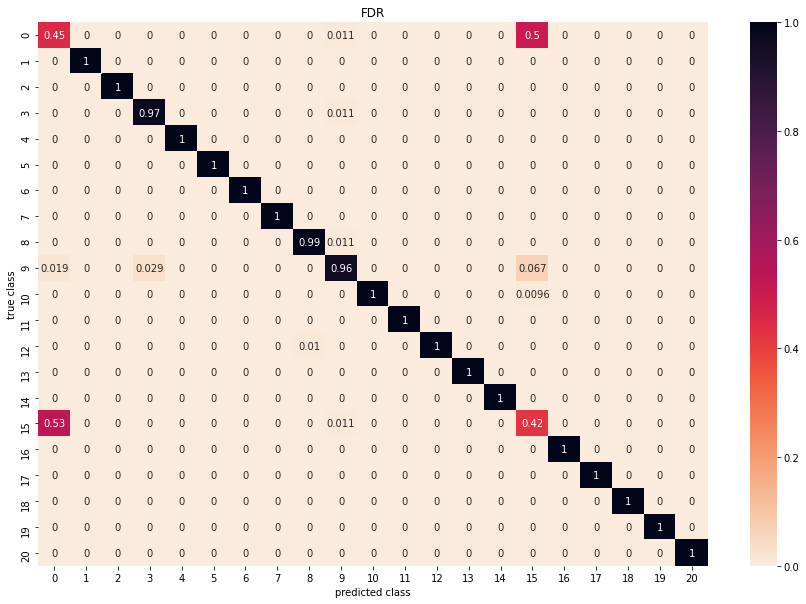

In [46]:
plt.figure(figsize=(15, 10))
plt.title("FDR")
sns.heatmap(confusion_matrix(y_true_val, y_ans_val, normalize='pred'), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

In [47]:
TPR, FPR, ACCURACY = get_metrics(y_true_val, y_ans_val)

In [48]:
def plotting(arr, name, forward=True):
    classes = np.arange(len(arr))

    norm = plt.Normalize(arr.min(), arr.max())
    
    if forward:
        colors = plt.cm.RdYlGn(norm(arr))
    else:
        colors = plt.cm.summer(norm(arr))
        
    plt.figure(figsize=(8, 5))
    plt.title(f'{name} per class')
#     sns.barplot(x=classes, y=arr, palette=colors)
    plt.plot(arr, '-*', color='yellowgreen')
    plt.xticks(classes, ["fault_" + str(c) if c > 0 else "normal" for c in classes], rotation=90)
    plt.xlabel('class')
    plt.ylabel(f'{name}')
    plt.ylim(0, 1.1)
    plt.show()

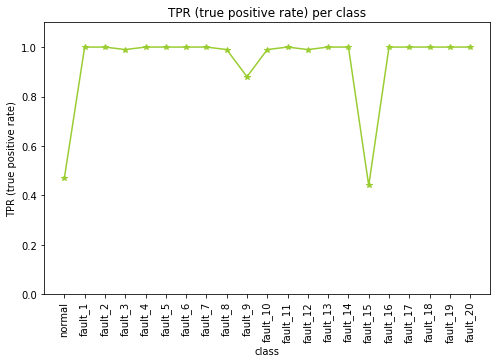

In [49]:
plotting(TPR, "TPR (true positive rate)")

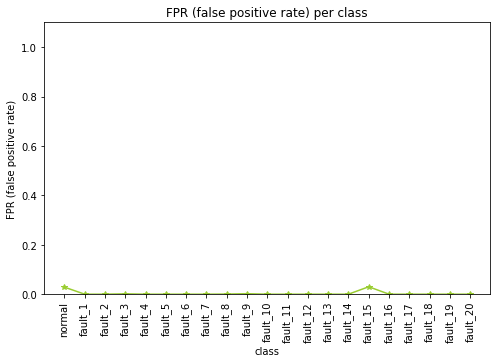

In [50]:
plotting(FPR, "FPR (false positive rate)", forward=False)

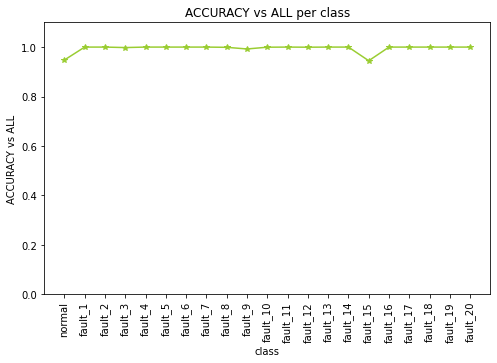

In [51]:
plotting(ACCURACY, "ACCURACY vs ALL")

> ### Test evaluation

In [65]:
gc.collect()

11879

In [53]:
#reading test data in .R format
a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [54]:
raw_test[features] = scaler.transform(raw_test[features])

In [55]:
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1
raw_test = raw_test.set_index('index')

In [56]:
raw_test.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
index,,,,,,,,,,,,,,,,,,,,,
0.0,0,1.0,1,-0.061905,0.201545,-0.366697,0.396960,0.672885,0.349442,-0.223455,...,0.036876,-0.280430,-0.477229,-0.047406,0.017518,0.678059,0.641891,-0.185190,0.014966,-0.693145
0.0,0,1.0,2,-0.057595,-0.504438,0.575905,0.124438,0.421859,0.709238,-0.228836,...,-0.201046,-0.283523,-0.372900,-0.042150,0.002242,-0.482106,-0.595256,-0.173439,-0.142419,-0.548871
0.0,0,1.0,3,-0.084550,-0.483398,0.012553,-0.222560,0.110240,-0.271443,-0.251702,...,-0.059070,-0.263817,-0.348612,-0.062236,0.011582,1.286104,-0.800952,-0.174777,-0.062251,0.333051
0.0,0,1.0,4,-0.063137,-0.829377,0.121173,-0.098154,0.421859,-0.105874,-0.246322,...,-0.086261,-0.279133,-0.173902,-0.082698,0.016885,0.675348,0.681334,-0.177046,-0.119325,-0.335875
0.0,0,1.0,5,-0.295060,-0.186512,0.597077,-0.170677,-0.002289,0.123376,-0.195209,...,-0.193666,-0.417724,-0.176248,-0.042244,-0.176629,0.075099,-0.747937,-0.171810,-0.087889,-0.022812


In [57]:
class DataTEST(Dataset):

    def __init__(self, X, seq_length):
    
        self.X = X
        self.seq_length = seq_length
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique()
    
    def __getitem__(self, idx):

        features = self.X.loc[idx][self.features].values[160 : (161+self.seq_length), :]
        target = self.X.loc[idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [66]:
%%time

SEQ_LENGTH = [1, 5, 10, 25, 50, 100, 200, 250, 300]
metrics = dict()
y_ans_test_all = []

for seq_length in SEQ_LENGTH:
    
    y_ans_test, y_true_test = [], []
    
    test_ds = DataTEST(raw_test, seq_length=seq_length)
    test_dl = DataLoader(test_ds, batch_size=512)

    start = time.time()
    print(f'seq_length: {seq_length}\n')

    model.eval()
    for (X_batch_test, y_batch_test) in tqdm(test_dl):
        
        print(X_batch_test.size())
        
        X_batch_lengths_test = torch.tensor([seq_length]*len(X_batch_test)).to(device)

        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

        y_pred_test = model(X_batch_test, X_batch_lengths_test)

        y_pred_prob = F.softmax(y_pred_test.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_test += y_pred_class.tolist()
        y_true_test += y_batch_test.tolist()
        
        end = time.time()
        
    y_ans_test_all.append(y_ans_test)
        
    TPR, FPR, ACCURACY = get_metrics(y_true_test, y_ans_test)
    
#     print("Classes True", round(pd.Series(y_true_test).value_counts(normalize=True).sort_index(), 4).to_dict())
#     print("Classes False", round(pd.Series(y_ans_test).value_counts(normalize=True).sort_index(), 4).to_dict())
    
#     print("TPR", np.round(TPR, 4))
#     print("FPR", np.round(FPR, 4))
#     print("ACCURACY", np.round(ACCURACY, 4))
    
    metrics[seq_length] = [TPR, FPR, ACCURACY]
    
    print(f"seq_length time: {end - start}")  

seq_length: 1



torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([512, 2, 52])
torch.Size([260, 2, 52])

seq_length time: 269.8061020374298
seq_length: 5



torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([260, 6, 52])

seq_length time: 270.23665595054626
seq_length: 10



torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([512, 11, 52])
torch.Size([260, 11, 52])

seq_length time: 271.70848083496094
seq_length: 25



torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([260, 26, 52])

seq_length time: 268.48092103004456
seq_length: 50



torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([260, 51, 52])

seq_length time: 268.9372715950012
seq_length: 100



torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([260, 101, 52])

seq_length time: 268.99941658973694
seq_length: 200



torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([512, 201, 52])
torch.Size([260, 201, 52])

seq_length time: 272.17405438423157
seq_length: 250



torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([512, 251, 52])
torch.Size([260, 251, 52])

seq_length time: 272.42332339286804
seq_length: 300



torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([512, 301, 52])
torch.Size([260, 301, 52])

seq_length time: 273.5782353878021
CPU times: user 40min 53s, sys: 6.3 s, total: 40min 59s
Wall time: 40min 36s


In [67]:
y_ans_test_all = np.array(y_ans_test_all).T
y_true_test_all = np.array(y_true_test).T

y_ans_test_all.shape, y_true_test_all.shape

((10500, 9), (10500,))

In [68]:
detection_delay = get_detection_delay(y_true=y_true_test_all, y_pred=y_ans_test_all)

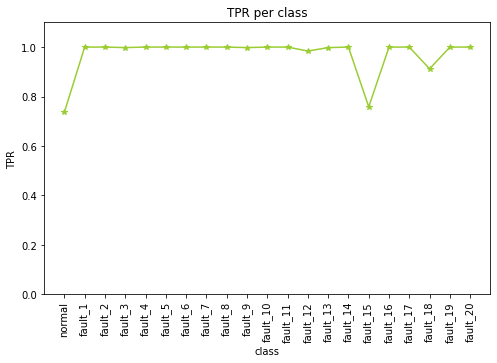

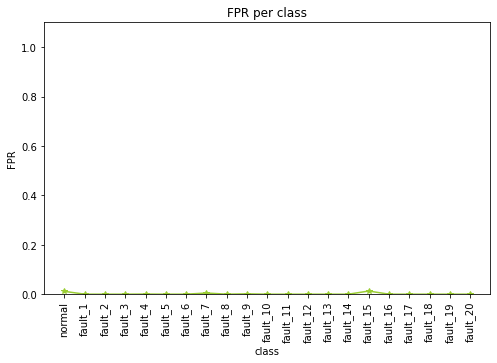

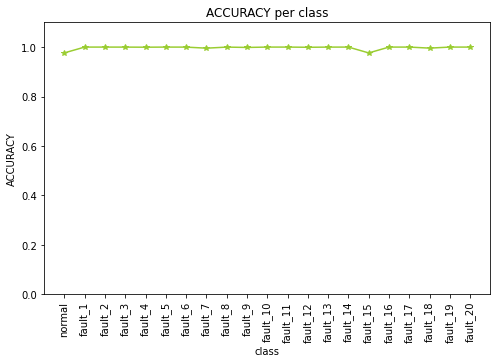

In [69]:
plotting(metrics[seq_length][0], "TPR")
plotting(metrics[seq_length][1], "FPR")
plotting(metrics[seq_length][2], "ACCURACY")

In [70]:
detection_delay_mean = {}
for (k, v) in detection_delay.items():
    detection_delay_mean[k] = np.nanmean(v)

In [71]:
detection_delay_mean

{0: 3.9254658385093166,
 1: 4.97,
 2: 5.622,
 3: 2.996,
 4: 0.1,
 5: 5.94,
 6: 3.51,
 7: 2.782,
 8: 3.91,
 9: 0.446,
 10: 3.722,
 11: 3.134,
 12: 2.824,
 13: 4.142,
 14: 1.4,
 15: 2.9613821138211383,
 16: 3.366,
 17: 4.036,
 18: 4.724,
 19: 2.354,
 20: 4.47}

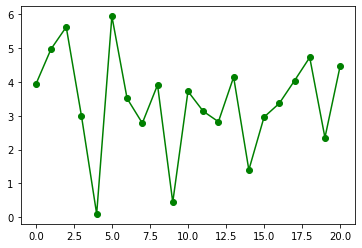

In [72]:
plt.plot(np.array(list(detection_delay_mean.values())), '-go')
plt.show()

In [ ]:
class TwinModel(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        self.lstm_1 = nn.LSTM(
                        input_size=self.input_size[0], 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.lstm_2 = nn.LSTM(
                        input_size=self.input_size[1],
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=2*self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x_1 = x[:, :, :41]
        x_2 = x[:, :, 41:]
        
        x_1, _ = self.lstm_1(x_1)
        x_2, __ = self.lstm_2(x_2)
        
        x_3 = torch.cat((x_1[:, -1], x_2[:, -1]), dim=-1)
        
        x = self.head(x_3)
        
        return x